# Getting started: Skeleton analysis with Skan

Skeleton analysis allows us to measure fine structure in samples. In this case, we are going to measure the network formed by a protein called *spectrin* inside the membrane of a red blood cell, either infected by the malaria parasite *Plasmodium falciparum*, or uninfected.

## 0. Extracting a skeleton from an image

Skan's primary purpose is to analyse skeletons. (It primarily mimics the ["Analyze Skeleton" Fiji plugin](https://imagej.net/AnalyzeSkeleton).) In this section, we will run some simple preprocessing on our source images to extract a skeleton, provided by Skan and [scikit-image](https://scikit-image.org), but this is far from the optimal way of extracting a skeleton from an image. Skip to section 1 for Skan's primary functionality.

First, we load the images. These images were produced by an FEI scanning electron microscope. [ImageIO](https://imageio.github.io) provides a method to read these images, including metadata.

In [2]:
from glob import glob
import imageio as iio

files = glob('example-data/*.tif')
image0 = iio.imread(files[0], format='fei')

We display the images with [Matplotlib](http://matplotlib.org).

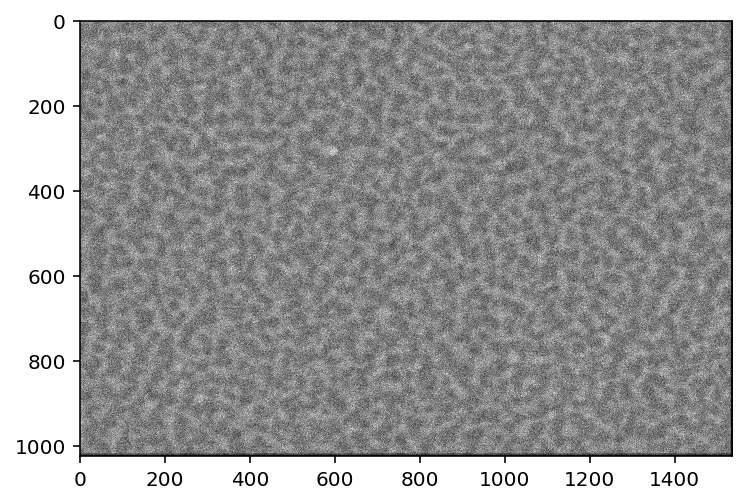

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

fig, ax = plt.subplots()
ax.imshow(image0, cmap='gray');

As an aside, we can extract the pixel spacing in meters from the `.meta` attribute of the ImageIO image:

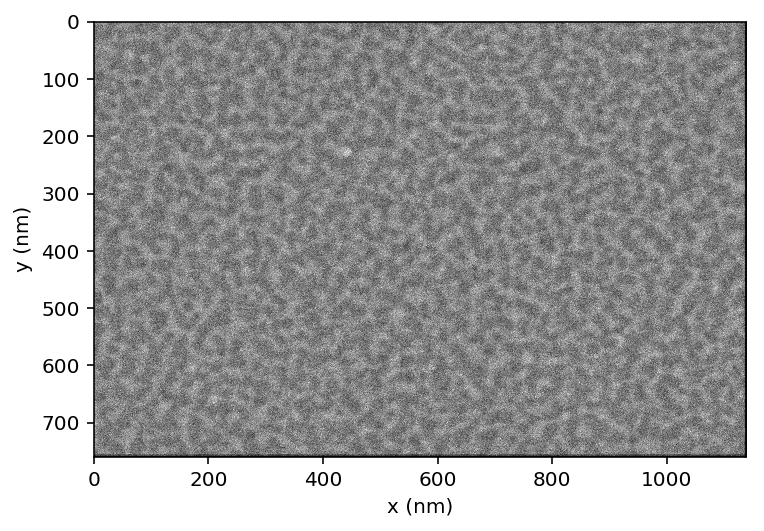

In [5]:
spacing = image0.meta['Scan']['PixelHeight']
spacing_nm = spacing * 1e9  # nm per pixel
dim_nm = np.array(image0.shape) / spacing_nm

fig, ax = plt.subplots()
ax.imshow(image0, cmap='gray',
          extent=[0, dim_nm[1], dim_nm[0], 0]);
ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)');

This is an image of the inside of the membrane of a red blood cell. We want to measure the network of bright regions in this image, which is made up of a protein called *spectrin*. Our strategy will be to:

- smooth the image with Gaussian smoothing
- threshold the image with Sauvola thresholding (Otsu thresholding also works)
- skeletonise the resulting binary image

These steps can be performed by a single function in Skan, `skan.pre.threshold`. We use parameters derived from the metadata, so that our analysis is portable to images taken at slightly different physical resolutions.

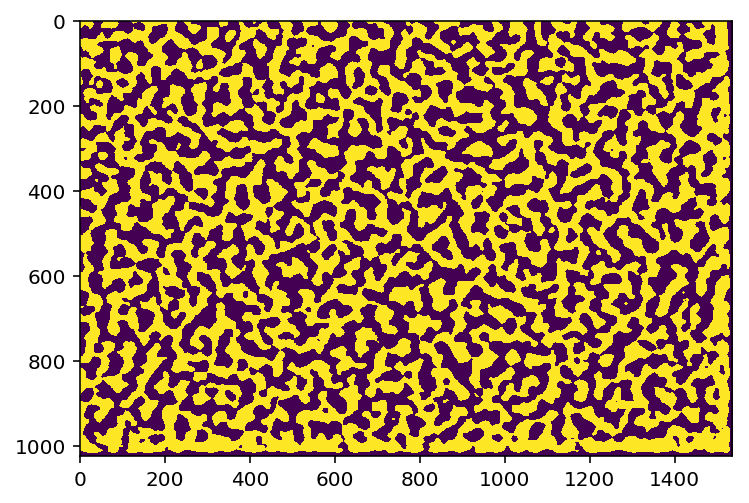

In [6]:
from skan.pre import threshold

smooth_radius = 5 / spacing_nm  # float OK
threshold_radius = int(np.ceil(50 / spacing_nm))
binary0 = threshold(image0, sigma=smooth_radius,
                    radius=threshold_radius)

fig, ax = plt.subplots()
ax.imshow(binary0);

(There are some thresholding artifacts around the edges, due to the dark border caused by microscope imaging drift and alignment. We will ignore this in this document, but the Skan GUI allows for a "crop" parameter to filter out these regions.)

Finally, we skeletonise this binary image:

In [7]:
from skimage import morphology

skeleton0 = morphology.skeletonize(binary0)

Skan has functions for drawing skeletons in 2D:

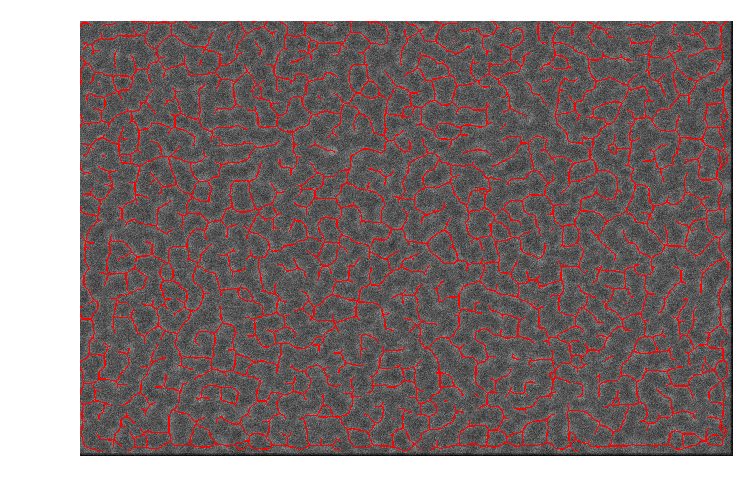

In [9]:
from skan import draw

fig, ax = plt.subplots()
draw.overlay_skeleton_2d(image0, skeleton0, dilate=1, axes=ax);

## 1. Measuring the length of skeleton branches

Now that we have a skeleton, we can use Skan's primary functions: producing a network of skeleton pixels, and measuring the properties of branches along that network.

In [12]:
from skan import csr

pixel_graph, coordinates, degrees = csr.skeleton_to_csgraph(skeleton0)

The pixel graph is a SciPy [CSR matrix]() in which entry $(i, j)$ is 0 if pixels $i$ and $j$ are not connected, and otherwise is equal to the distance between pixels $i$ and $j$ in the skeleton. This will normally be 1 between adjacent pixels and $\sqrt{2}$ between diagonally adjacent pixels, but in this can be scaled by a `spacing=` keyword argument that sets the scale (and this scale can be different for each image axis). In our case, we know the spacing between pixels, so we can measure our network in physical units instead of pixels:

In [13]:
pixel_graph0, coordinates0, degrees0 = csr.skeleton_to_csgraph(skeleton0,
                                                               spacing=spacing_nm)

The second variable contains the coordinates (in pixel units) of the points in the pixel graph. Finally, `degrees` is an image of the skeleton, with each skeleton pixel containing the number of neighbouring pixels. This enables us to distinguish between *junctions* (where three or more skeleton branches meet), *endpoints* (where a skeleton ends), and *paths* (pixels on the inside of a skeleton branch.

These intermediate objects contain all the information we need from the skeleton, but in a more useful format. It is still difficult to interpret, however, and the best option might be to visualise a couple of minimal examples. Skan provides a function to do this. (Because of the way NetworkX and Matplotlib draw networks, this method is only recommended for very small networks.)

In [33]:
reload(draw)

<module 'skan.draw' from '/Users/jni/projects/skan/skan/draw.py'>

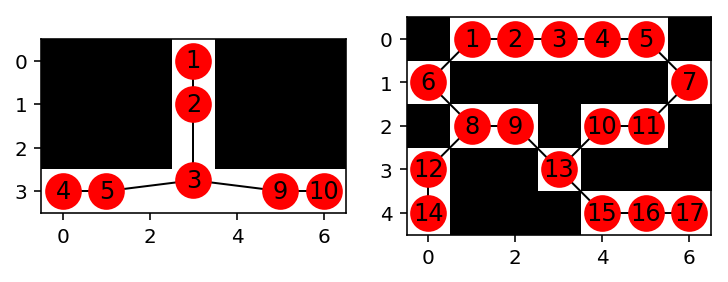

In [34]:
from skan import _testdata
g0, c0, _ = csr.skeleton_to_csgraph(_testdata.skeleton0)
g1, c1, _ = csr.skeleton_to_csgraph(_testdata.skeleton1)
fig, axes = plt.subplots(1, 2)

draw.overlay_skeleton_networkx(g0, c0, image=_testdata.skeleton0,
                               axis=axes[0])
draw.overlay_skeleton_networkx(g1, c1, image=_testdata.skeleton1,
                               axis=axes[1])

The function `skan.csr.summarise` uses this graph to trace the path from junctions (node 3 in the left graph, 8 and 13 in the right graph) to endpoints (1, 4, and 10 on the left, and 14 and 17 on the right) and other junctions. It then produces a junction graph and table in the form of a pandas DataFrame.

Let's go back to the red blood cell image to illustrate this graph.

In [35]:
branch_data = csr.summarise(skeleton0, spacing=spacing_nm)
branch_data.head()

,branch-distance,branch-type,coord-0-0,coord-0-1,coord-1-0,coord-1-1,euclidean-distance,img-coord-0-0,img-coord-0-1,img-coord-1-0,img-coord-1-1,node-id-0,node-id-1,skeleton-id
0,60.029571,1,0.0,163.22416,9.779960,217.182560,54.837547,0,121,7,161,1,330,1
1,22.006540,1,0.0,306.21392,10.791680,288.677440,20.590981,0,227,8,214,9,425,1
2,59.641843,0,0.0,326.44832,20.234400,372.312960,50.129793,0,242,15,276,10,831,2
3,50.835029,1,0.0,499.11520,36.871573,525.195093,45.162747,0,370,27,389,13,667,1
4,11.118993,0,0.0,546.32880,1.348960,555.771520,9.538588,0,405,1,412,17,62,3


The branch distance is the sum of the distances along path nodes between two nodes, in natural scale (given by `spacing`).

The branch type is coded by number as:

<ol start="0">
<li>endpoint-to-endpoint (isolated branch)</li>
<li>junction-to-endpoint</li>
<li>junction-to-junction</li>
<li>isolated cycle</li>
</ol>

Next come the coordinates in natural space, the Euclidean distance between the points, and the coordinates in image space (pixels). Finally, the unique IDs of the endpoints of the branch (these correspond to the pixel indices in the CSR representation above), and the unique ID of the skeleton that the branch belongs to.

This data table follows the "tidy data" paradigm, with one row per branch, which allows fast  exploration of branch statistics. Here, for example, we plot the distribution of branch lengths according to branch type:

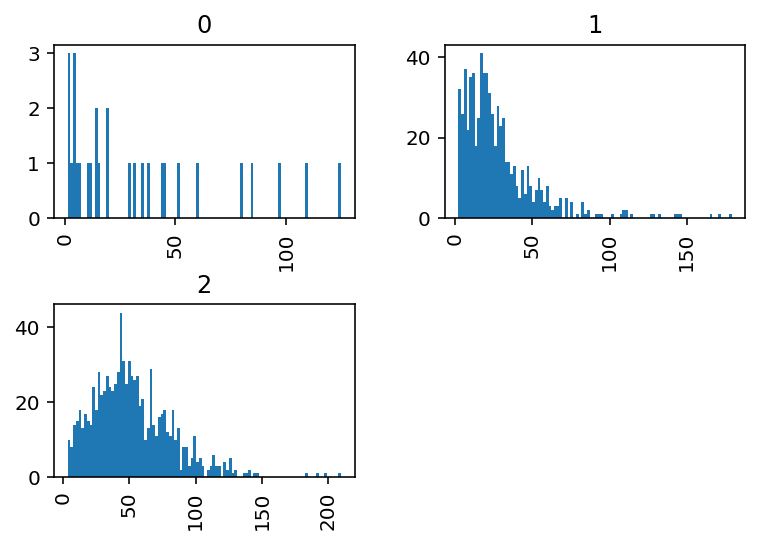

In [40]:
branch_data.hist(column='branch-distance', by='branch-type', bins=100);

We can see that junction-to-junction branches tend to be longer than junction-to-endpoint and junction isolated branches, and that there are no cycles in our dataset.

We can also represent this visually with the `overlay_euclidean_skeleton`, which colormaps branches according to a user-selected attribute in the table:

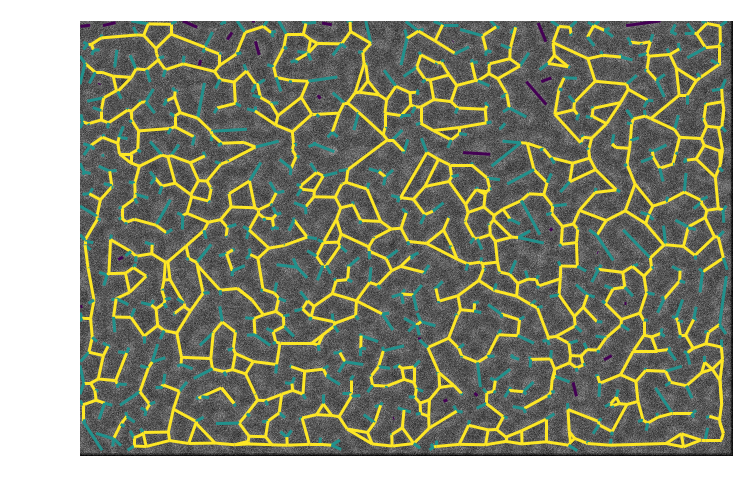

In [44]:
draw.overlay_euclidean_skeleton_2d(image0, branch_data,
                                   skeleton_color_source='branch-type');

## 2. Comparing different skeletons

Now we can use Python's data analysis tools to answer a scientific question: do malaria-infected red blood cells differ in their spectrin skeleton?

In [52]:
images = [iio.imread(file, format='fei')
          for file in files]
spacings = [image.meta['Scan']['PixelHeight']
            for image in images]
spacings_nm = 1e9 * np.array(spacings)


def skeletonize(images, spacings_nm):
    smooth_radii = 5 / spacings_nm  # float OK
    threshold_radii = np.ceil(50 / spacings_nm).astype(int)
    binaries = (threshold(image, sigma=smooth_radius,
                          radius=threshold_radius)
                for image, smooth_radius, threshold_radius
                in zip(images, smooth_radii, threshold_radii))
    skeletons = map(morphology.skeletonize, binaries)
    return skeletons


skeletons = skeletonize(images, spacings_nm)
tables = [csr.summarise(skeleton, spacing=spacing)
          for skeleton, spacing in zip(skeletons, spacings_nm)]

for filename, dataframe in zip(files, tables):
    dataframe['filename'] = filename

table = pd.concat(tables)

This analysis is quite verbose, which is why the `skan.pipe` module exists. It will be covered in a separate document.

Now, however, we have a tidy data table with information about the sample origin of the data, allowing us to analyse the effects of treatment on our skeleton measurement. We will use only junction-to-junction branches.

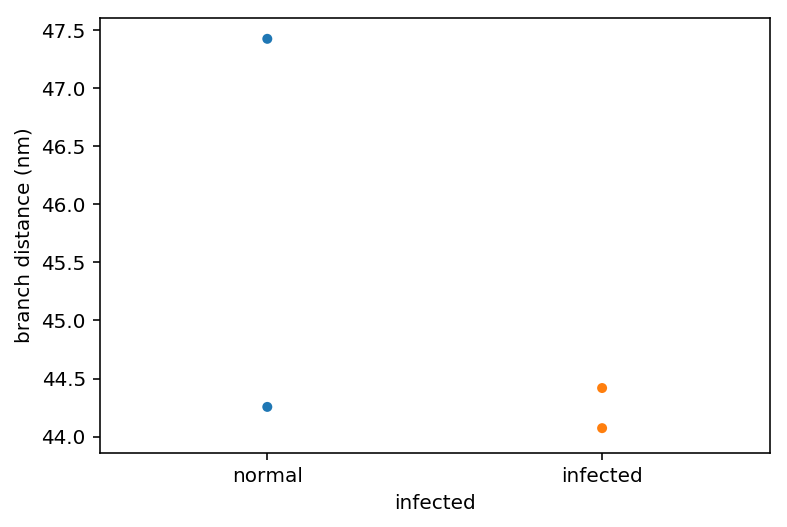

In [63]:
import seaborn.apionly as sns

j2j = (table[table['branch-type'] == 2].
       rename(columns={'branch-distance':
                       'branch distance (nm)'}))
per_image = j2j.groupby('filename').median()
per_image['infected'] = ['infected' if 'inf' in fn else 'normal'
                         for fn in per_image.index]
sns.stripplot(data=per_image,
              x='infected', y='branch distance (nm)',
              order=['normal', 'infected'])